## GMM: Anomaly Detection

We can use GMM for anomaly detection.

First, compute the likelihood (or log-likelihood) of the given data X (using the "score" method). Then, any instance located in a low-density region can be considered an anomaly. 

To decide whether a data point resides in a reasonable "low-density" region, we need to define a **density threshold**.

We use the following example from Geron (Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition) to illustrate **how to decide a threshold density**.

        In a manufacturing company that tries to detect defective products, the ratio of defective products is usually well known. Say it is equal to 4%. We then set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density. If we notice that you get too many false positives (i.e., perfectly good products that are flagged as defective), we can lower the threshold. Conversely, if we have too many false negatives (i.e., defective products that the system does not flag as defective), we can increase the threshold. 

In this notebook we identify the outliers using the **fourth percentile lowest density** as the threshold. I.e., approximately 4% of the instances will be flagged as anomalies.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

## Synthetic Dataset

We will use Scikit-Learn's "make_blobs" function to generate **isotropic Gaussian blobs** for clustering. 

This function provides greater control regarding the centers and standard deviations of each cluster.

In [2]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

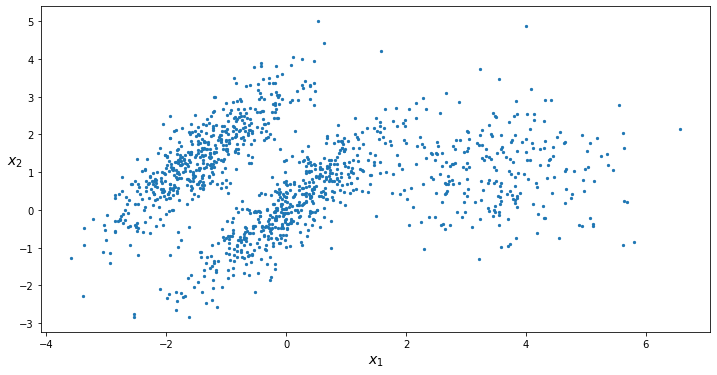

In [3]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap='autumn')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

## GMM

Since the dataset contains three clusters, we train the GMM model with $k$=3.

In [4]:
gmm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## Finding Anomalies

To determine whether a data point is an anomaly we need to compute the log-likelihood of the given data.

- We use the "score_samples" method to compute the log-likelihood of each sample in X.

Then, compare the likelihood values with the density threshold.

#### Setting the Threshold

For this problem, the threshold is at the fourth percentile lowest density.

For defining the threshold, we use the numpy.percentile()function. It computes the nth percentile of the given data (array elements) along the specified axis. 

For further detail: https://numpy.org/doc/stable/reference/generated/numpy.percentile.html

In [5]:
# Create a GMM object and estimate the model parameters
gmm = GaussianMixture(n_components=3, n_init=10)
gmm.fit(X)

# Compute the log-likelihood of each sample
densities = gmm.score_samples(X)

# Define the threshold is at the fourth percentile lowest density
density_threshold = np.percentile(densities, 4) 

# Get the anomalous samples
anomalies = X[densities < density_threshold]

## Plot the Clusters & Density Regions

It is useful to visualize the density contours created by the GMM model.

This will help us to determine which data points reside in the low-density regions. Those are the likely anomalies.

Then, we show the anomalies on the density plot.

We use the following functions for showing density regions as well as the cluster means and the decision boundaries (using dashed lines).

In [6]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

## Plot Anomalies

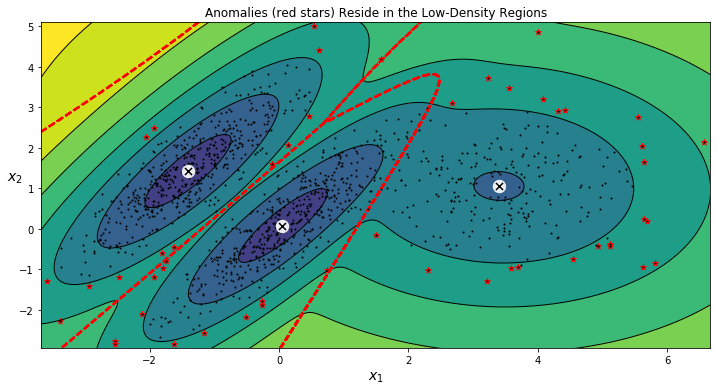

In [7]:
plt.figure(figsize=(12, 6))
plt.title("Anomalies (red stars) Reside in the Low-Density Regions")

plot_gaussian_mixture(gmm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()